## Linear Discriminant Analysis

First let's generate some multivariate gaussian data, separated into 3 classes.

In [7]:
import numpy as np
import pandas as pd
from typing import Dict
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [2]:
mu_1 = np.array([0, 0])
mu_2 = np.array([3, 0])
mu_3 = np.array([0, 3])

pi_1 = 1/3
pi_2 = 1/3
pi_3 = 1/3

mus = {1: mu_1, 2: mu_2, 3: mu_3}
pis = {1: pi_1, 2: pi_3, 3: pi_3}

cov = np.array([[1, 0], [0, 1]])
gen = np.random.default_rng()

We're creating the dataset and plotting it here.

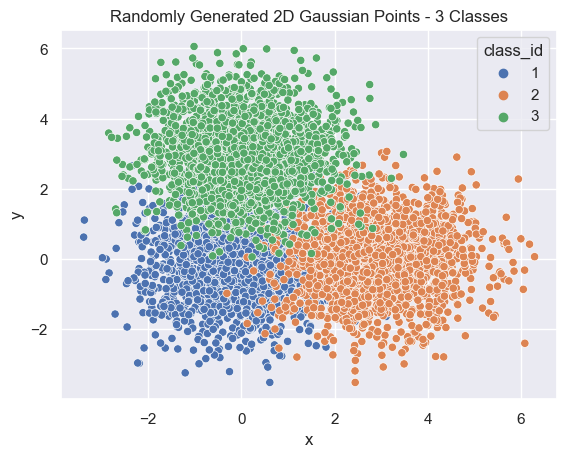

In [6]:
def create_2d_gaussian_points(mu, cov, class_id, num_points=2000):
    x, y = gen.multivariate_normal(mu, cov, num_points).T
    return pd.DataFrame({'x': x, 'y': y, 'class_id': class_id})

c1_points = create_2d_gaussian_points(mu_1, cov, '1')
c2_points = create_2d_gaussian_points(mu_2, cov, '2')
c3_points = create_2d_gaussian_points(mu_3, cov, '3')

data = pd.concat([c1_points, c2_points, c3_points])
sns.scatterplot(data, x='x', y='y', hue='class_id').set(title='Randomly Generated 2D Gaussian Points - 3 Classes');

Let $G$ be the random variable indicating class membership, so $G \in \{1, 2, 3\}$. Let $f_k(x)$ denote the density of $G = k$ given $x$. Further let $\pi_x$ denote the prior probability of belonging to class $k$. 

We know that $$P(G = k | X = x) = \frac{f_k(x)\pi_k}{\sum_i f_i(x)\pi_i}$$
by the Baye's rule. The cool thing is that if $f_k$ is Gaussian and $\Sigma$ (covariance) is the same across all $f_k$, then the decision boundary between classes is piecewise linear.

This can be concluded by looking at the log-odds. We have for any $i, k$ that $$log \frac{P(G = k | X = x)}{P(G = i | X = x)} = \log\frac{f_k(x)}{f_i(x)} + \log\frac{\pi_k}{\pi_i}$$
$$= \log\frac{\pi_k}{\pi_i} - \frac{1}{2}(\mu_k + \mu_i)^{\top}\Sigma^{-1}(\mu_k - \mu_i) + x^{\top}\Sigma^{-1}(\mu_k - \mu_i)$$
$$= a_{ki} + x^{\top}b_{ki}$$

where $$a_{ki}= \log\frac{\pi_k}{\pi_i} - \frac{1}{2}(\mu_k + \mu_i)^{\top}\Sigma^{-1}(\mu_k - \mu_i)$$ and  $$b_{ki}= \Sigma^{-1}(\mu_k - \mu_i)$$

This leads to a decision rule for calculating the most probable class given $x$.

### Decision Rule

We will classify a point $x$ as belonging to class $k$ if $P(G =k |X = k) > P(G =k |X = i)$ for all $i \neq k$. 

Note that $$P(G =k |X = k) > P(G =k |X = i) \;\forall i \neq k$$
$$\iff log \frac{P(G = k | X = x)}{P(G = i | X = x)} > 0  \;\forall i \neq k$$
$$\iff a_{ki} + x^{\top}b_{ki} > 0 \;\forall i \neq k$$

Geometrically, this means that the region where we classify a point as belonging to class $k$ is defined by linear inequalities. In our particular example with 3 classes in 2 dimensions, the decision region is fan shaped. 

You could use this decision rule to perform classification. Start at 1, 2 and at every step compare two indices pairwise, only remembering the one for which the inequality is greater than zero. However, it's must more straightforward to calculate $$argmax_k \log(f_k(x)\pi_k)$$

which is basically the term of $P(G = k | X = x)$ with largest numerator. The only reason why we go through the argument above is to show that the decision boundaries will actually be piecewise linear.

To confirm, we plot the decision boundary for this problem below:

In [9]:
# create mesh

nx, ny = (100, 100)
x = np.linspace(data.x.min() - 1, data.x.max() + 1, nx)
y = np.linspace(data.y.min() - 1, data.y.max() + 1, ny)
xv, yv = np.meshgrid(x, y)
xy_stack = np.stack([xv, yv]).reshape((2, -1))
xy_stack.shape

(2, 10000)

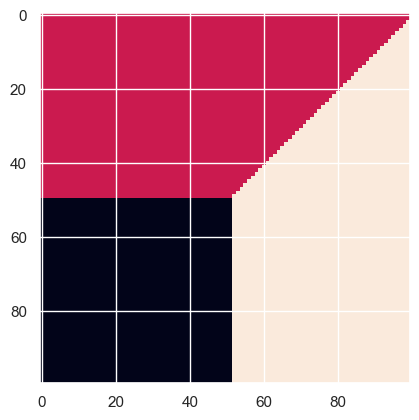

In [11]:
# for 2d case only
class LDABayesRule:
    # means is a dictionary {class_label : class_mean}
    def __init__(self, cov: np.array, means: Dict[str, np.array], priors: Dict[str, np.array]) -> None:
        self.invcov = np.linalg.inv(cov)
        self.means = means
        self.priors = priors

    def discriminant_k(self, xy: np.array, class_mean: np.array, class_prior: float):
        return xy.T @ self.invcov @ class_mean - 0.5 * class_mean.T @ self.invcov @ class_mean + np.log(class_prior)

    def predict(self, xy: np.array):
        class_preds = []
        for class_label in self.means.keys():
            class_mean = self.means[class_label]
            class_prior = self.priors[class_label]
            preds = self.discriminant_k(xy, class_mean, class_prior)
            class_preds.append(preds)
        
        return np.argmax(np.stack(class_preds, axis=1), axis=1)


clf = LDABayesRule(cov, mus, pis)
preds = clf.predict(xy_stack)

plt.imshow(np.rot90(preds.reshape((nx, ny))));

In practice, we don't know the parameters needed to obtain the Baye's rule. So we need to estimate

$$\hat{\pi}_k = \frac{N_k}{N}$$

$$\hat{\mu}_k = \frac{\sum_{i = 1, G_i = k}^{N_k} X_i}{N_k}$$

$$\hat{\Sigma} = \sum_{k = 1}^{K} \sum_{G_i = k} (x_i - \hat{\mu_k})(x_i - \hat{\mu_k})^{\top}/ (N - K)$$

The last estimator is not intuitive, but it's basically the pooled or average variance across classes, corrected using the appropriate degrees of freedom. Another equivalent way to write it would be $$\hat{\Sigma} = \frac{\sum_{k = 1}^K X_k^{\top}X_k}{N - K}$$

where $X_k$ is the $N_k \times p$ matrix of observations in class $k$, centered by $\hat{\mu_k}$. 

## A note on QDA

If we remove the assumption that $\Sigma$ is same across all classes, then we get QDA (Quadratic Discrminant Analysis), which yields a quadratic decision boundary. We can see this by reproducing the same argument with log-odds. This results in the following form: $$x^{\top}(\Sigma_k^{-1} - \Sigma_l^{-1})x + x^\top b + a > 0$$ for some constants $a, b$. 

## Relation to Logistic Regression

Logistic regression follows the same paradigm as LDA, but we directly try to estimate the log odds decision boundaries using iteratively weighted least squres:

$$log \frac{P(G = 1 | X = x)}{P(G = K | X = x)} = a_1 + b_1x$$
$$\dots$$
$$log \frac{P(G = K - 1 | X = x)}{P(G = K | X = x)} = a_{K -1} + b_{K - 1}x$$

Logistic regression ignores the marginal probability $P(X)$, while this is fully defined for LDA because of our distributional assumptions. There is a discussion of this on page 128 of the book. The general concensus is that logistic regression is more robust. Interestingly enough, it does not converge if the data is fully seperable.

## Relation to Naive Bayes

Naive Bayes is a generalization of LDA!

This is because we can write Naive Bayes in additive form as $$log \frac{P(G = i | X = x)}{P(G = k | X = x)} = a_{ik} + \sum_{j = 1}^p g_{ikj}(x_j)$$